# Transfer Learning FaceSwap
We present a fake detection task on FaceSwap manipulation, performed with the use of a pre-trained **EfficientNetV2 model**. We try to evaluate the performance of the network using transfer learning in two different way:

*   Take the weights of the pretrained model as intial weigths and fine-tuning the pre-trained *EfficientNetV2 model* on the *FaceSwap dataset*
*   Freezing the weights of all the layer of the pretrained model and going to add, as last layer, one linear layers with a ReLu activation function, which is the only one retrained on the *FaceSwap dataset*.

## IMPORT

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import random
import matplotlib.image as mpimg
import pandas as pd
from google.colab import drive
import cv2
from keras.callbacks import ModelCheckpoint, EarlyStopping

cudnn.benchmark = True
plt.ion()   # interactive mode
torch.cuda.empty_cache()

##Load Data


###Folder

In [ ]:
drive.mount('/content/drive/')
data_dir = '/content/drive/MyDrive/VISIOPE_PROJECT/DataVisionSet_faceswap/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive/


##DataLoader with augmentation and normalization
> In the following block, we create the ImageFolder (one for the train and one for the validation set), and the dataloaders, necessary for the training phase.
In particular we create batches of 4 images.



In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
image_datasets["val"]
image_datasets["train"]

Dataset ImageFolder
    Number of datapoints: 1600
    Root location: /content/drive/MyDrive/VISIOPE_PROJECT/DataVisionSet_faceswap/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

##Visualize a few images


> Function to visualize few images


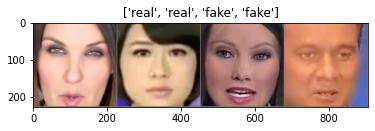

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Define train_model function



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience = 7):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss=[]
    val_loss=[]

    train_acc=[]
    val_acc=[]

    best_val_loss = np.inf
    wait = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
              
            if phase=='train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc.item())
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return {'model': model, 'train_loss':train_loss, 'val_loss':val_loss, 'train_acc': train_acc, 'val_acc': val_acc}


## Visualizing the model predictions

Generic function to display predictions for a few images



In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            print(f'Labels:{labels}')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            print(f'Prediction:{preds}')
            print(f'Input size: {inputs.size()[0]}')
            print(f'Class names: {class_names}')

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## EFFICIENTNET V2 M

> `EfficientNet architecture` is designed to improve the trade-off between accuracy and computational cost by scaling the network's dimensions in a balanced way. By using `compound scaling, depthwise separable convolutions` and `AutoML`, it is able to achieve state-of-the-art accuracy with fewer parameters and less computation than previous architectures.


> In this situation, we create a pre-trained *EfficientNet model*, trained on Imagenet, named `model_ft`, and we retrain it on the Faceswap dataset.

> There, we use an *SGD optimizer*, with a initial learning rate really low ( `lr=0.001`) with a *StepLR scheduler*.

In [ ]:
model_ft = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights)
num_ftrs = model_ft.classifier[1].in_features

# Here the size of each output sample is set to 2.
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

In [ ]:
model_ft

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## FINETUNING THE EFFICIENTNET V2 M FREEZING INITIAL LAYERS


> In this situation instead, we create a ResNet pre-trained model, `model_ft_freeze`, we freeze all the weigths of the network and finally we add a `nn.Sequential` composed of one linear layers with a Relu in between.

For this case, we use an *SGD optimezer* with an *StepLR scheduler* which decrease the learning rate every 7 epochs.


In [ ]:
model_ft_freeze = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights)

for param in model_ft_freeze.parameters():
    param.requiresGrad = False

num_ftrs = model_ft_freeze.classifier[1].in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_freeze.classifier[1] = nn.Linear(num_ftrs, 2)

model_ft_freeze = model_ft_freeze.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft_freeze.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_ft_freeze

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## Train and evaluate



###Train Finetuning

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

model_ft output:
Best val Acc: 0.965000

###Train Finetuning with freezed layers

In [ ]:
model_ft_freeze = train_model(model_ft_freeze, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5496 Acc: 0.7125
val Loss: 0.3389 Acc: 0.8800
Epoch 1/49
----------
train Loss: 0.3251 Acc: 0.8638
val Loss: 0.2220 Acc: 0.9100
Epoch 2/49
----------
train Loss: 0.2285 Acc: 0.8988
val Loss: 0.5955 Acc: 0.7650
Epoch 3/49
----------
train Loss: 0.1571 Acc: 0.9344
val Loss: 0.1316 Acc: 0.9600
Epoch 4/49
----------
train Loss: 0.0905 Acc: 0.9594
val Loss: 0.1067 Acc: 0.9550
Epoch 5/49
----------
train Loss: 0.0740 Acc: 0.9675
val Loss: 0.3520 Acc: 0.8650
Epoch 6/49
----------
train Loss: 0.0822 Acc: 0.9706
val Loss: 0.1538 Acc: 0.9400
Epoch 7/49
----------
train Loss: 0.0426 Acc: 0.9800
val Loss: 0.1298 Acc: 0.9550
Epoch 8/49
----------
train Loss: 0.0332 Acc: 0.9850
val Loss: 0.1121 Acc: 0.9550
Epoch 9/49
----------
train Loss: 0.0268 Acc: 0.9881
val Loss: 0.1387 Acc: 0.9400
Epoch 10/49
----------
train Loss: 0.0216 Acc: 0.9925
val Loss: 0.1110 Acc: 0.9650
Epoch 11/49
----------
train Loss: 0.0279 Acc: 0.9850
val Loss: 0.1174 Acc: 0.9550
Epoch 12/49
----------
train Loss: 0

# Visualize few image of the model without freezing layers

Labels:tensor([0, 1, 1, 0], device='cuda:0')
Prediction:tensor([0, 1, 1, 0], device='cuda:0')
Input size: 4
Class names: ['fake', 'real']


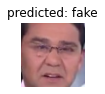

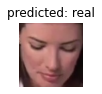

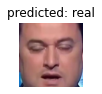

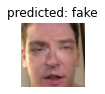

Labels:tensor([1, 1, 0, 1], device='cuda:0')
Prediction:tensor([1, 1, 0, 1], device='cuda:0')
Input size: 4
Class names: ['fake', 'real']


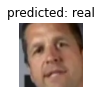

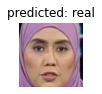

In [ ]:
visualize_model(model_ft["model"])

plt.ioff()
plt.show()

# Visualize few image of the model with freezing layers

Labels:tensor([1, 0, 0, 1], device='cuda:0')
Prediction:tensor([1, 0, 0, 1], device='cuda:0')
Input size: 4
Class names: ['fake', 'real']


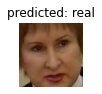

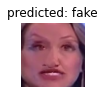

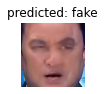

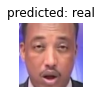

Labels:tensor([1, 1, 1, 0], device='cuda:0')
Prediction:tensor([1, 1, 1, 0], device='cuda:0')
Input size: 4
Class names: ['fake', 'real']


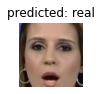

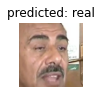

In [ ]:
visualize_model(model_ft_freeze["model"])

plt.ioff()
plt.show()

# Plot Train Loss and Accuracy



> In this section we plot the `training` and `validation loss` and the `accuracy` of our model without freezing layers.


##Plot results

In [ ]:
def plot_loss(train_loss, valid_loss, title: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(train_loss))), train_loss, label='Train loss')
    plt.plot(list(range(len(valid_loss))), valid_loss, label='Valid loss')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

    plt.show()

In [ ]:
def plot_acc(train_acc, valid_acc, title: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(train_acc))), train_acc, label='Train accuracy')
    plt.plot(list(range(len(valid_acc))), valid_acc, label='Valid accuracy')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper right")

    plt.show()

##Results Fine-Tuning

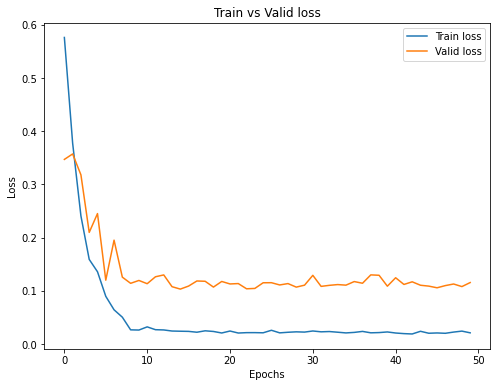

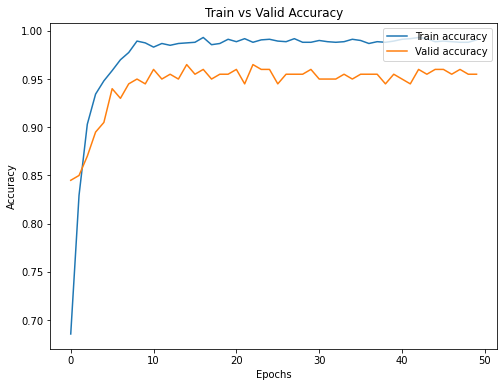

In [ ]:
plot_loss(model_ft['train_loss'], model_ft['val_loss'], 'Train vs Valid loss')
plot_acc(model_ft['train_acc'], model_ft['val_acc'], 'Train vs Valid Accuracy')

# Plot Train Loss and Accuracy



> In this section we plot the `training` and `validation loss` and the `accuracy` of our model with freezing layers.


##Results Fine-Tuning freezed layers

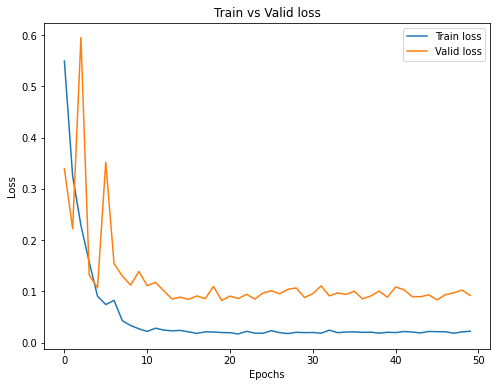

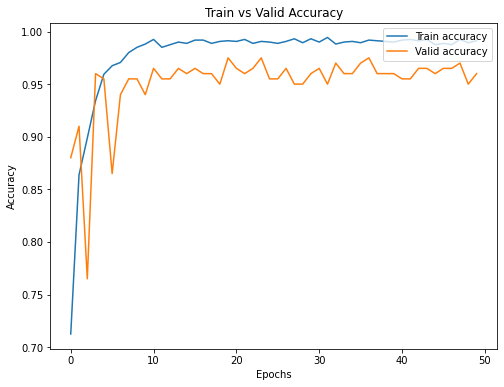

In [ ]:
plot_loss(model_ft_freeze['train_loss'], model_ft_freeze['val_loss'], 'Train vs Valid loss')
plot_acc(model_ft_freeze['train_acc'], model_ft_freeze['val_acc'], 'Train vs Valid Accuracy')

## Save the models

In [ ]:
%cd /content/drive/MyDrive/VISIOPE_PROJECT/models

/content/drive/.shortcut-targets-by-id/1SD-LhXJK1ufMgPEQVdrk_U7c2Xa0_bCF/VISIOPE_PROJECT/models


In [ ]:
torch.save(model_ft["model"].state_dict(), 'efficientnet_faceswap_NORMAL.p') 

### Freezed layers

In [ ]:
torch.save(model_ft_freeze["model"].state_dict(), 'efficientnet_faceswap_FREEZE.p')